In [110]:
import os
import sys
src_path = sys.path[0].replace("paper_working", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("paper_working", "output")

import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

rc_={
    "figure.dpi":300,
    "font.size":10,
    "axes.facecolor":"white",
    "savefig.facecolor":"white",
    "text.usetex":False,
    "legend.frameon":False
}
plt.rcParams.update(rc_)


from plot_helper import *

from utils.plot_utils import *
customize_plt() # customize plt configs, see plot_utils

In [111]:
# get the predictions and calculate the errors

methods=['DeepAR_optuna','LR_NAIVE','LR_PCo','TFT_optuna','XGB']
df=pd.read_csv(r'L:\Coding_project\Energy_grid_new\data\UCSD_raw_data\BLD_Sum.csv',index_col=0)
df.index=pd.to_datetime(df.index)
df_pred=df[pd.Timestamp(2019,1,1,0,0):pd.Timestamp(2019,12,31,23,45)]

for method in methods:
    fn=os.path.join('L:\Coding_project\Energy_grid_new\data\load_forecast',method,'BLD_Sum.csv')
    df=pd.read_csv(fn,index_col=0)
    df.index=pd.to_datetime(df.index)
    df.rename(columns={'RealPower':method},inplace=True)
    try:
        df_pred=pd.merge(df_pred,df,on='DateTime')
    except:
        ...
    
df_error=df_pred.drop(columns=['RealPower_before_scaling'])   
for key in methods:
    df_error[key]=df_error[key]-df_error['RealPower']

In [112]:
for scale in [0.04,0.05,0.06,0.07,0.1,0.02,0.03,0.08]:
    noises = np.random.uniform(low=-1, high=1, size=len(df_pred))
    absolute_average = np.mean(np.abs(noises))
    adjustment_factor = scale / absolute_average
    noises=noises*adjustment_factor
    df_error['noise_{}'.format(str(scale))]=df_error['RealPower']*noises

In [113]:
df_error

,RealPower,DeepAR_optuna,LR_NAIVE,LR_PCo,TFT_optuna,XGB,noise_0.04,noise_0.05,noise_0.06,noise_0.07,noise_0.1,noise_0.02,noise_0.03,noise_0.08
DateTime,,,,,,,,,,,,,,
2019-01-01 00:00:00,52.3299,-1.546005,1.608912,1.927050,5.767505,-1.700402,-1.825396,-2.083790,-6.245516,1.792776,4.817677,-1.314208,-2.705493,5.109844
2019-01-01 00:15:00,51.4773,-1.408977,1.775533,1.473357,5.139773,-0.847802,1.326961,-1.376564,-3.089232,0.258159,-0.965042,0.797900,-2.562242,-8.202110
2019-01-01 00:30:00,51.2424,-1.520127,1.877271,1.769042,2.991215,-0.230265,3.766286,-4.992916,-4.559534,-1.581107,1.595253,1.132572,-3.053907,-0.240475
2019-01-01 00:45:00,50.9020,-1.450341,2.025977,1.350539,3.674824,-0.208488,-1.073117,-4.627060,0.836487,0.538776,-10.064196,1.068610,-1.709816,-6.873752
2019-01-01 01:00:00,51.7313,-2.646639,1.175377,0.231948,3.066701,-1.473570,-3.016687,1.030221,-0.125256,2.403111,10.265942,1.820827,0.238201,-5.945586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 22:45:00,48.4871,2.684017,3.656792,3.547053,14.036866,2.178556,1.180536,-3.671990,3.144898,-5.689214,0.872337,0.248385,2.655502,5.464098
2019-12-31 23:00:00,48.3798,0.986959,3.308924,2.903561,9.681827,0.812678,1.651718,1.960141,-3.693673,-0.621484,7.921398,0.946229,0.175008,4.027110
2019-12-31 23:15:00,47.2761,0.716764,3.425301,2.548005,8.091104,0.756808,2.639401,2.697352,-0.734959,6.393100,9.455367,1.647857,-0.168819,-0.778149


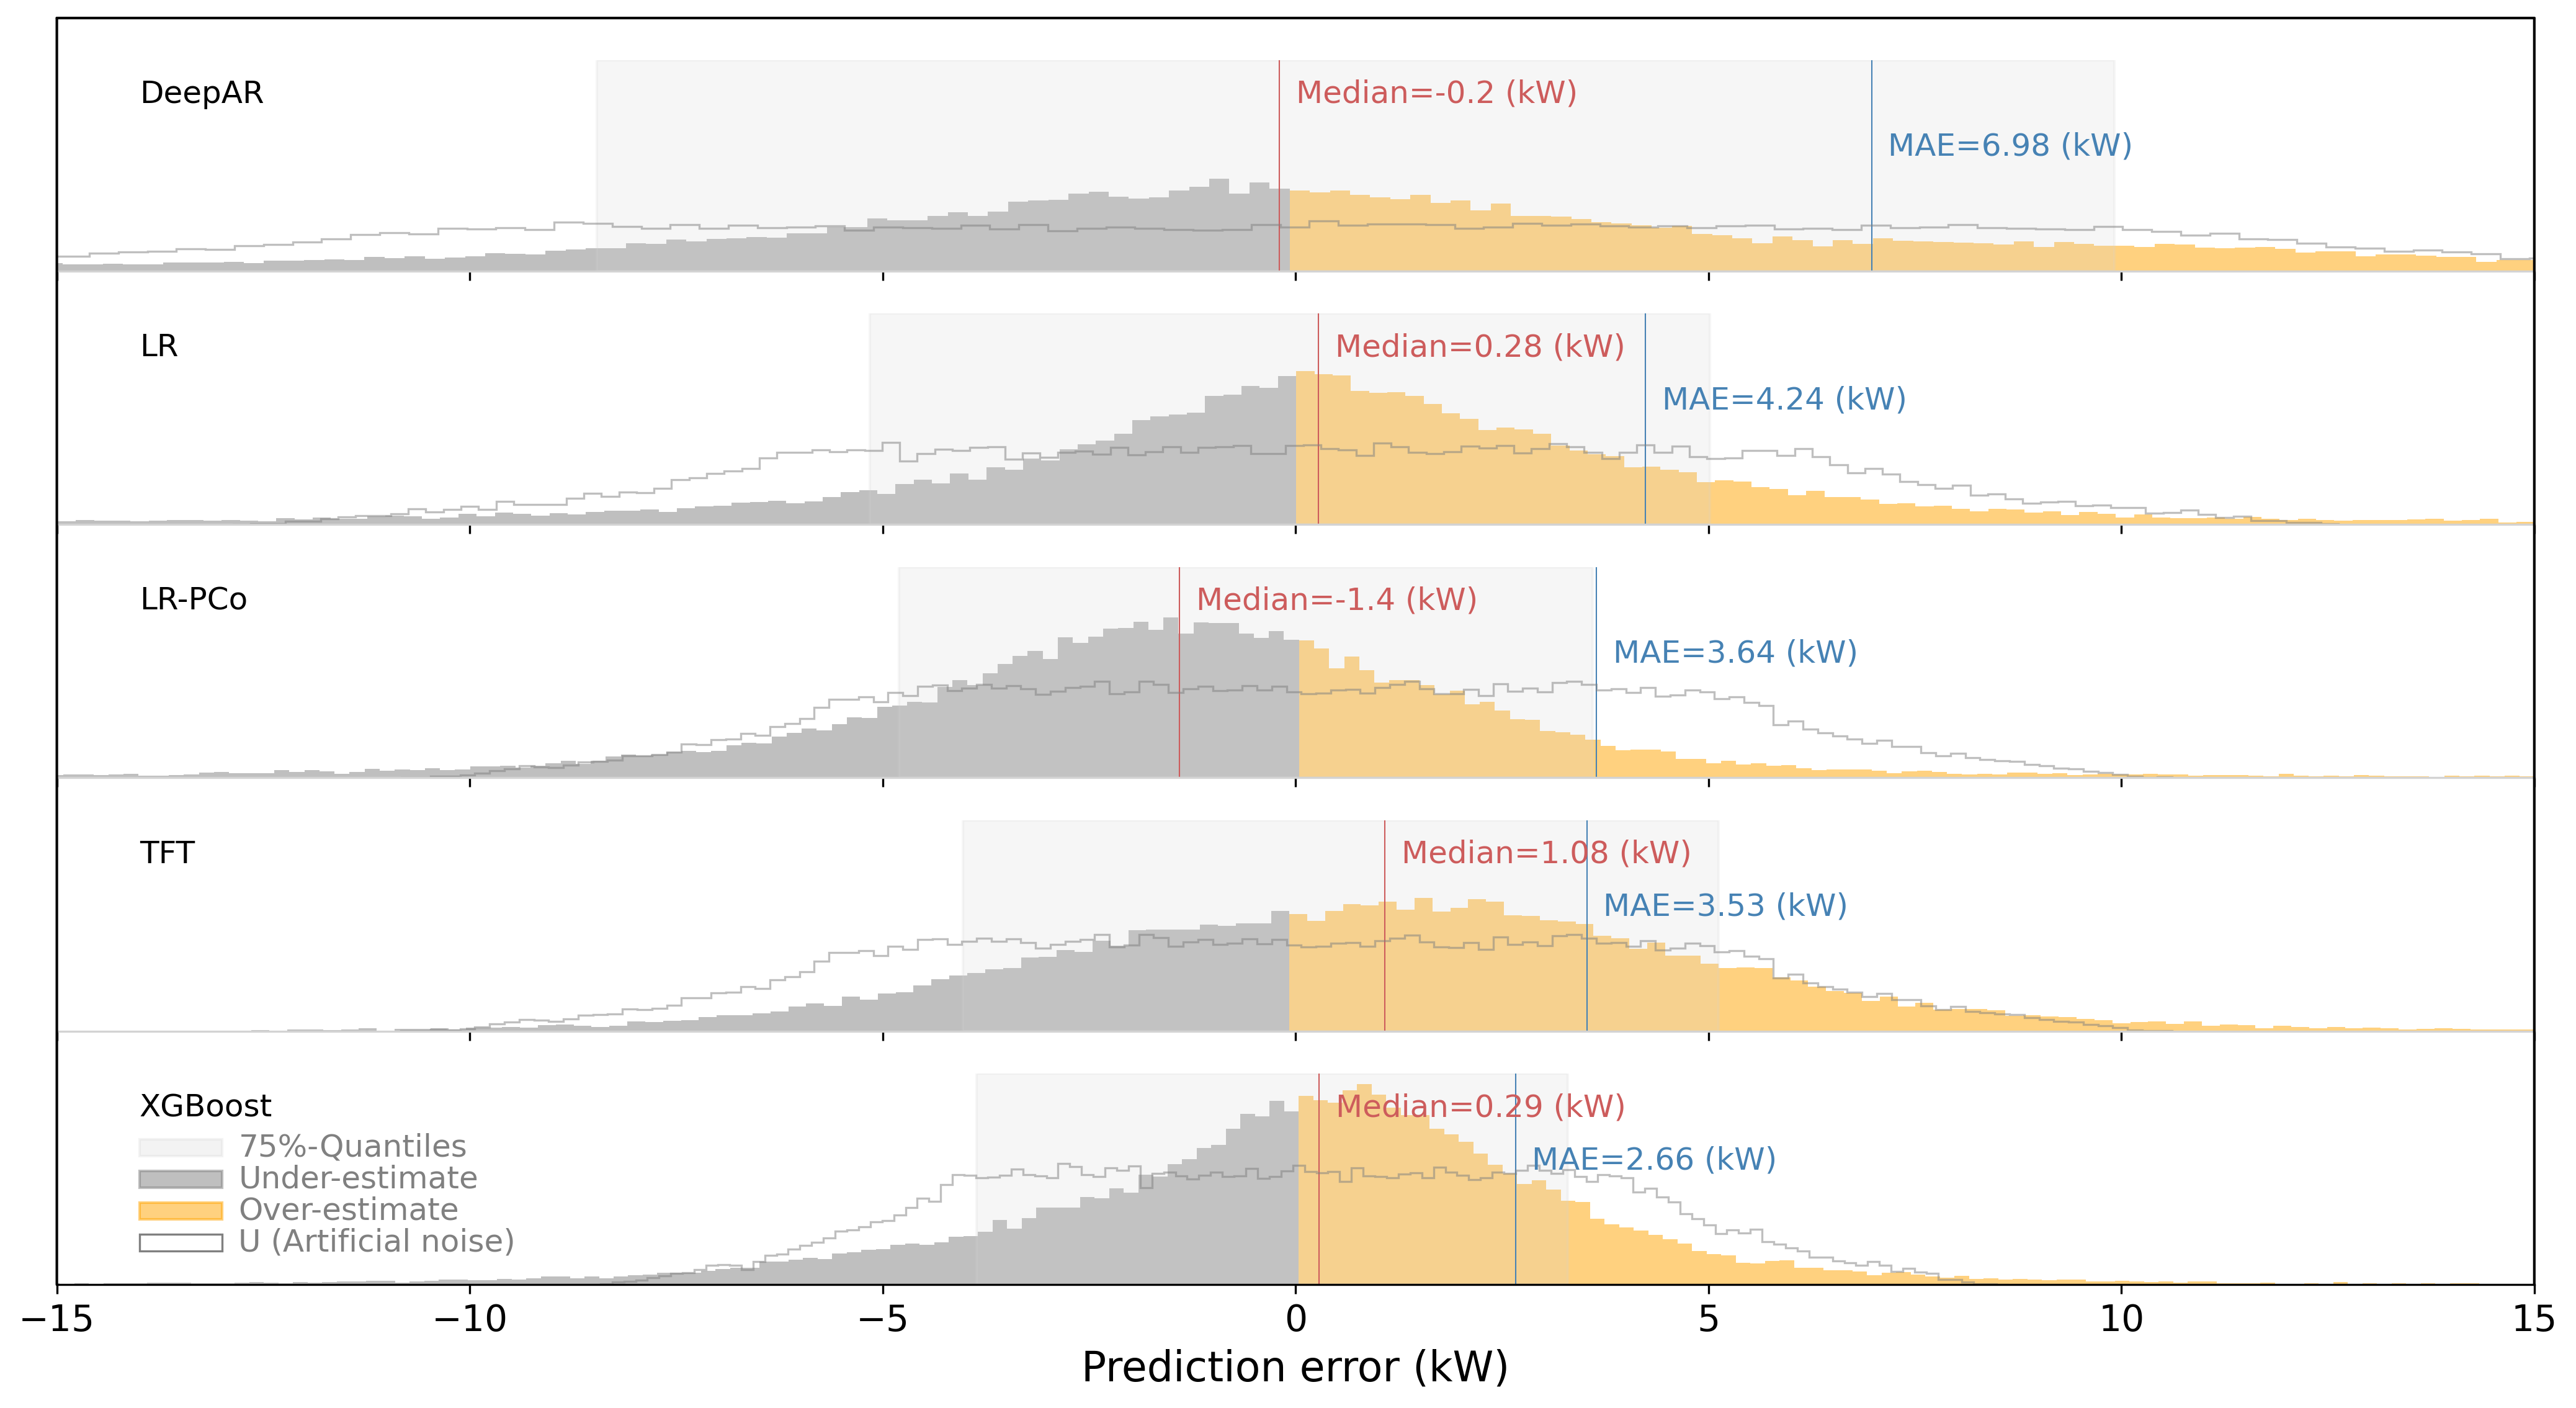

In [114]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import scipy
from matplotlib.patches import ConnectionPatch
def get_quantile(values,pos,quantile):
    #print(values)
    if pos:
        index=int(len(values)*quantile)
        values=np.sort(values)
        #print(values)
        return values[index]
    else:
        index=int(len(values)*(1-quantile))
        values=np.sort(values)
        return values[index]
def plot_stacked_hist(df_error,keys,labels,xlim=[-25,25],figsize=(14,10),quantile=0.75,draw_ref=False,ref_dic=None):
    n=len(keys)
    fig,axs=plt.subplots(n,1,figsize=figsize,sharex=True,sharey=True)
    k=0
    
    #xlim=[-25,25]
    for key in keys:
        counts, edges, patches = axs[k].hist(np.array(df_error[key]),bins=500,label=key,alpha=0.5,linewidth=0,density=True)
        mae=np.nanmean(abs(np.array(df_error[key])))
        med=np.nanmedian(np.array(df_error[key]))
        pos_quant=get_quantile(list(df_error[df_error[key]>0][key]),True,quantile)
        neg_quant=get_quantile(list(df_error[df_error[key]<0][key]),False,quantile)
        axs[k].axvline(mae,0,1,color='steelblue',linewidth=0.5)
        axs[k].axvline(med,0,1,color='indianred',linewidth=0.5)
        axs[k].axvspan(neg_quant,pos_quant,0,1,alpha=0.2,color='lightgray')
        '''samples=np.array(df_error[df_error[key]>-25][key])+25
        shape, loc, scale = scipy.stats.lognorm.fit(samples, floc=0)
        centers = 0.5*(edges[:-1] + edges[1:])
        cdf = scipy.stats.lognorm.cdf(edges, shape, loc=loc, scale=scale)
        prob = np.diff(cdf)
        axs[k].plot(centers-25,samples.size*prob, 'k-', linewidth=2, label='Expected histogram')'''
        trans = transforms.blended_transform_factory(
            axs[k].transData, axs[k].transAxes)
        
        if draw_ref:
            n1, bins1, patches1 = axs[k].hist(np.array(df_error[ref_dic[key]]),bins=120,label=key,alpha=0.5,
                                              edgecolor="gray",histtype="step",linewidth=0.8,density=True)
            #axs[k].plot(bins1[:-1],n1,'-',linewidth=0.5)
        
        for bar in axs[k].containers[0]:
            # get x midpoint of bar
            x = bar.get_x() + 0.5 * bar.get_width()
            # set bar color based on x
            if x < 0:
                bar.set_color('gray')
            else:
                bar.set_color('orange')

        if round(len(keys)/(k+1))==2:
            #axs[k].set_ylabel("Density")
            ...
        
        if k<len(keys)-1:
            axs[k].spines['right'].set_color('none')
            axs[k].spines['left'].set_color('none')
            axs[k].spines['top'].set_color('none')
            axs[k].spines['bottom'].set_color('lightgray')
            axs[k].set_yticklabels([])
            axs[k].set_yticks([])
            #axs[k].set_xticks([])
        else:
            axs[k].spines['right'].set_color('none')
            axs[k].spines['left'].set_color('none')
            axs[k].spines['top'].set_color('none')
            #axs[k].spines['bottom'].set_color('none')
            axs[k].set_yticklabels([])
            axs[k].set_yticks([])
            #axs[k].set_xticks([])
            
            # plot legend
            axs[k].axvspan(-14,-13,0.61,0.69,alpha=0.25,color='lightgray')
            axs[k].text(-12.8,0.61,'{}%-Quantiles'.format(str(int(quantile*100))),color='gray',transform=trans)
            axs[k].axvspan(-14,-13,0.46,0.54,alpha=0.5,color='gray')
            axs[k].text(-12.8,0.46,'Under-estimate'.format(str(round(quantile,2))),color='gray',transform=trans)
            axs[k].axvspan(-14,-13,0.31,0.39,alpha=0.5,color='orange')
            axs[k].text(-12.8,0.31,'Over-estimate'.format(str(round(quantile,2))),color='gray',transform=trans)
            if draw_ref:
                axs[k].axvspan(-14,-13,0.16,0.24,alpha=1,facecolor='w',edgecolor='gray',linewidth=0.8)
                axs[k].text(-12.8,0.16,'U (Artificial noise)'.format(str(round(quantile,2))),color='gray',transform=trans)
                
            axs[k].set_xlabel('Prediction error (kW)')
            
        axs[k].set_xlim(xlim)
        #axs[k].set_ylim(ylim)
        axs[k].text(-14,0.8,labels[key],transform=trans) 
        axs[k].text(mae+0.2,0.55,'MAE={} (kW)'.format(str(round(mae,2))),color='steelblue',transform=trans)
        axs[k].text(med+0.2,0.8,'Median={} (kW)'.format(str(round(med,2))),color='indianred',transform=trans)

        
        k+=1
    
    

    con = ConnectionPatch(xyA=(0,0), xyB=(0,1.2), coordsA="axes fraction", coordsB="axes fraction",axesA=axs[n-1], axesB=axs[0], 
                          color="black",linewidth=1)
    axs[n-1].add_artist(con)
    
    con = ConnectionPatch(xyA=(1,0), xyB=(1,1.2), coordsA="axes fraction", coordsB="axes fraction",axesA=axs[n-1], axesB=axs[0], 
                          color="black",linewidth=1)
    axs[n-1].add_artist(con)
    
    con = ConnectionPatch(xyA=(0,1.2), xyB=(1,1.2), coordsA="axes fraction", coordsB="axes fraction",axesA=axs[0], axesB=axs[0], 
                          color="black",linewidth=1)
    axs[0].add_artist(con)
    #ax2.add_artist(con)
    fig.tight_layout()
    

labels={
    'DeepAR_optuna':'DeepAR',
    'LR_NAIVE':'LR',
    'LR_PCo':'LR-PCo',
    'TFT_optuna':'TFT',
    'XGB':'XGBoost'
}
ref_dic={
    'DeepAR_optuna':'noise_0.1',
    'LR_NAIVE':'noise_0.06',
    'LR_PCo':'noise_0.05',
    'TFT_optuna':'noise_0.05',
    'XGB':'noise_0.04'
}
plot_stacked_hist(df_error,methods,labels,[-15,15],(14,1.5*5),draw_ref=True,ref_dic=ref_dic)

In [115]:
heuristic_df=pd.read_csv(r'L:\Coding_project\Energy_grid_new_exp_local\BLD_simple_grid_search\BLD_sum_Simple_prediction_K96_4weeks_0.1.csv',index_col=0)
steps=['E_1','E_4','E_48','E_96']
labels={
    'E_1':'K=1',
    'E_2':'K=2',
    'E_3':'K=3',
    'E_4':'K=4',
    'E_48':'K=48',
    'E_96':'K=96',
}
ref_dic={
    'E_1':'noise_0.02',
    'E_4':'noise_0.04',
    'E_48':'noise_0.07',
    'E_96':'noise_0.08',
}
heuristic_df.index=pd.to_datetime(heuristic_df.index)
heuristic_df=pd.merge(heuristic_df,df_error,left_index=True,right_index=True,how='inner')

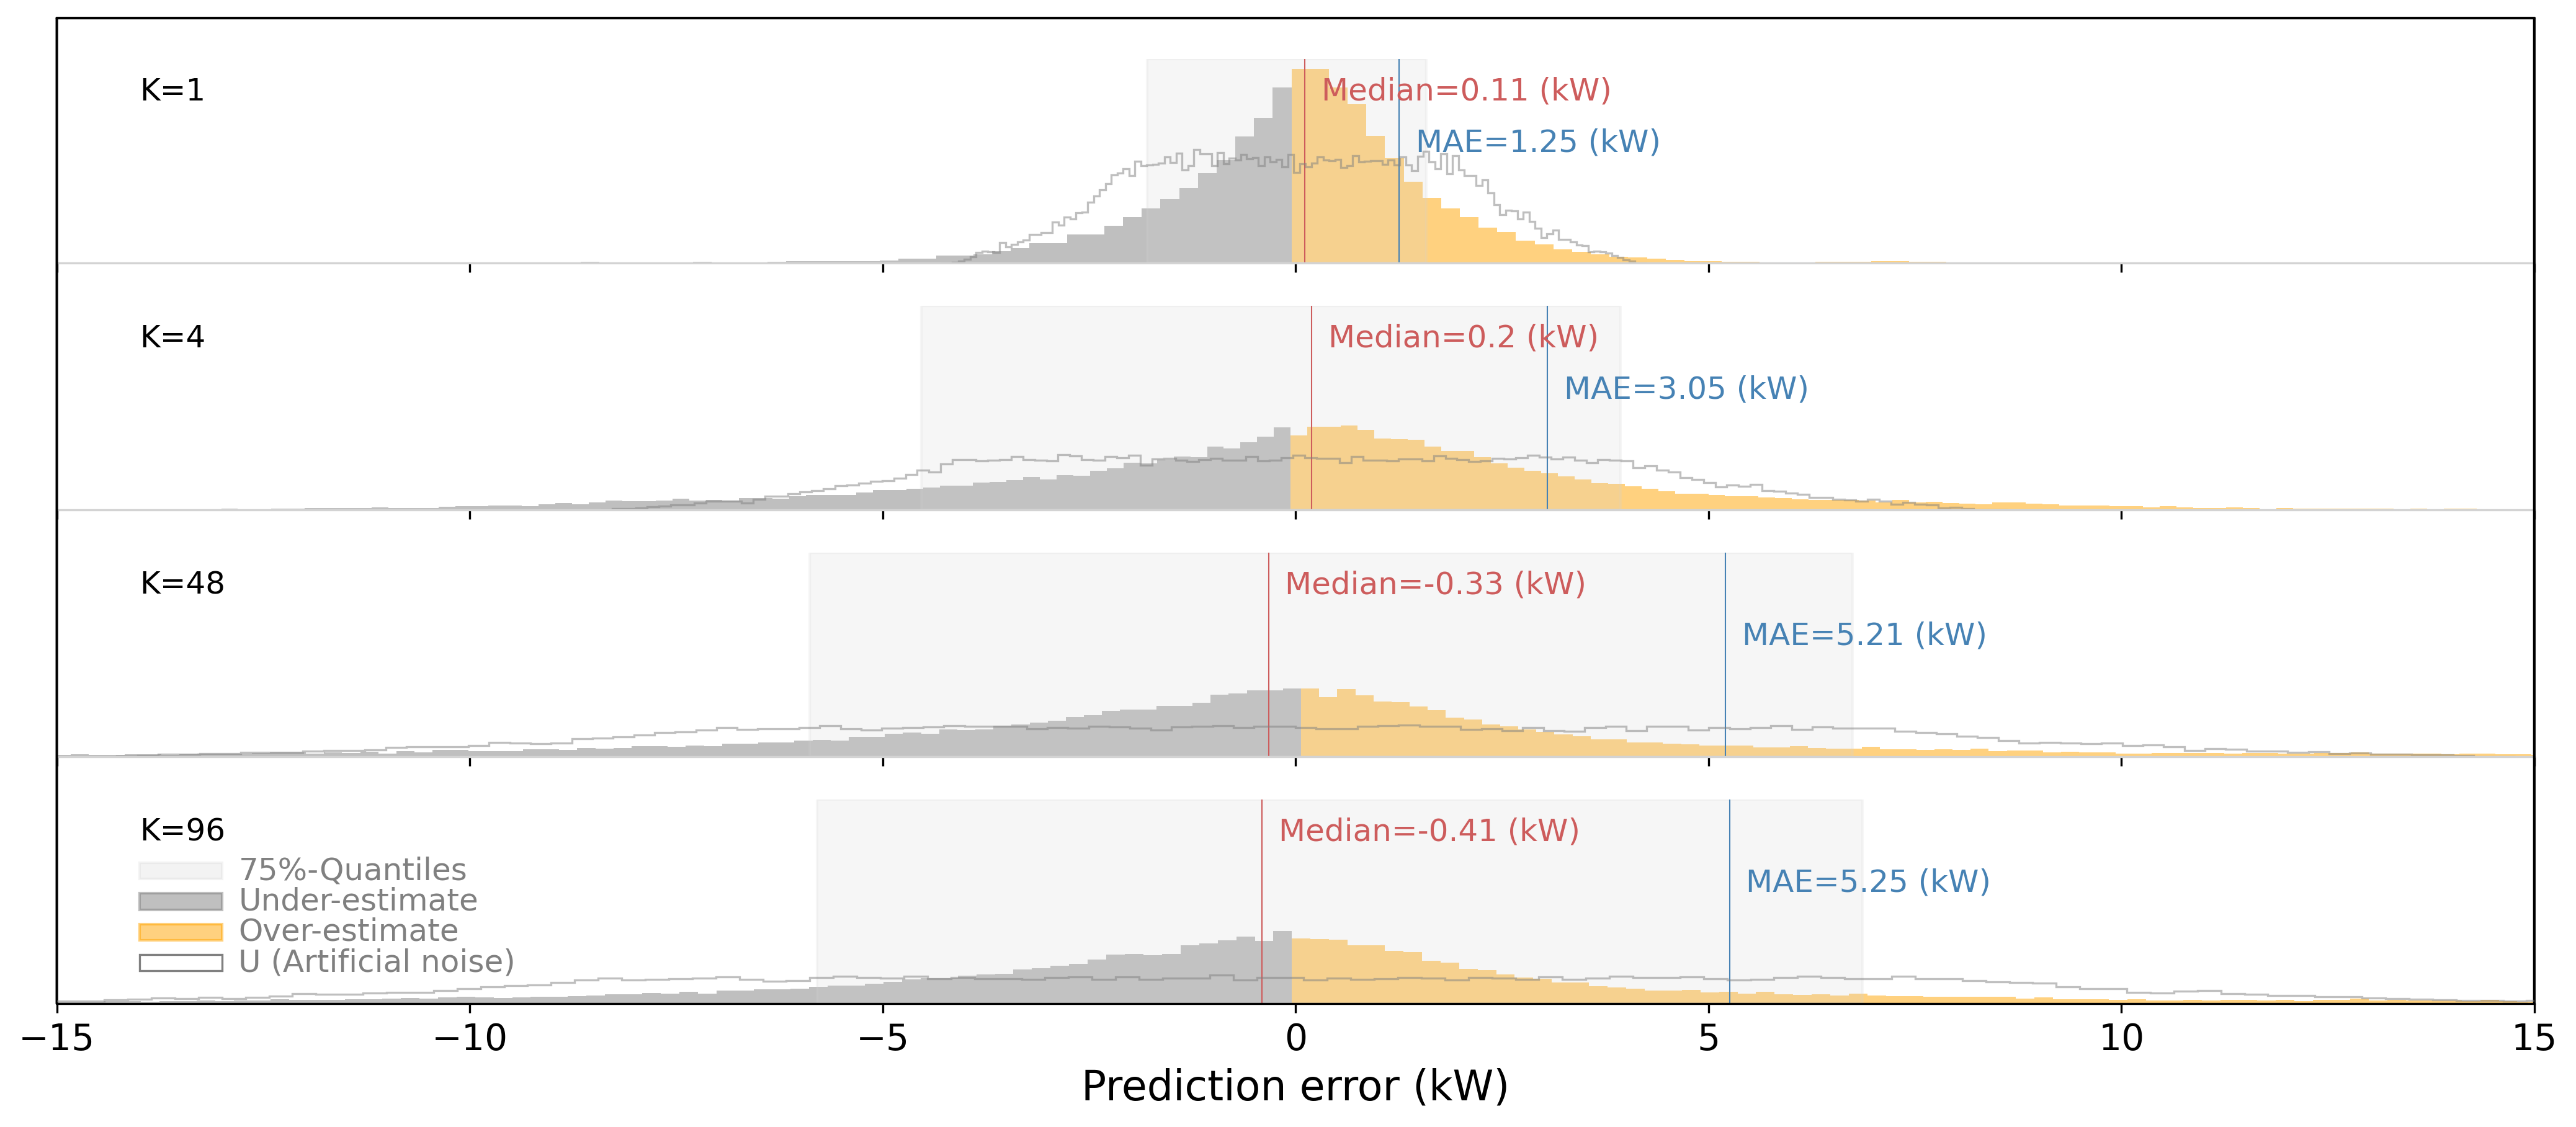

In [117]:
plot_stacked_hist(heuristic_df,steps,labels,[-15,15],(14,1.5*4),draw_ref=True,ref_dic=ref_dic)